# The Project #
1. This is a project with minimal scaffolding. Expect to use the the discussion forums to gain insights! It’s not cheating to ask others for opinions or perspectives!
2. Be inquisitive, try out new things.
3. Use the previous modules for insights into how to complete the functions! You'll have to combine Pillow, OpenCV, and Pytesseract
4. There are hints provided in Coursera, feel free to explore the hints if needed. Each hint provide progressively more details on how to solve the issue. This project is intended to be comprehensive and difficult if you do it without the hints.

### The Assignment ###
Take a [ZIP file](https://en.wikipedia.org/wiki/Zip_(file_format)) of images and process them, using a [library built into python](https://docs.python.org/3/library/zipfile.html) that you need to learn how to use. A ZIP file takes several different files and compresses them, thus saving space, into one single file. The files in the ZIP file we provide are newspaper images (like you saw in week 3). Your task is to write python code which allows one to search through the images looking for the occurrences of keywords and faces. E.g. if you search for "pizza" it will return a contact sheet of all of the faces which were located on the newspaper page which mentions "pizza". This will test your ability to learn a new ([library](https://docs.python.org/3/library/zipfile.html)), your ability to use OpenCV to detect faces, your ability to use tesseract to do optical character recognition, and your ability to use PIL to composite images together into contact sheets.

Each page of the newspapers is saved as a single PNG image in a file called [images.zip](./readonly/images.zip). These newspapers are in english, and contain a variety of stories, advertisements and images. Note: This file is fairly large (~200 MB) and may take some time to work with, I would encourage you to use [small_img.zip](./readonly/small_img.zip) for testing.

Here's an example of the output expected. Using the [small_img.zip](./readonly/small_img.zip) file, if I search for the string "Christopher" I should see the following image:
![Christopher Search](./readonly/small_project.png)
If I were to use the [images.zip](./readonly/images.zip) file and search for "Mark" I should see the following image (note that there are times when there are no faces on a page, but a word is found!):
![Mark Search](./readonly/large_project.png)

Note: That big file can take some time to process - for me it took nearly ten minutes! Use the small one for testing.

In [47]:
from zipfile import *

from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

import pytesseract
import cv2 as cv
import numpy as np

import kraken
from kraken import pageseg

import pytesseract

face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')

font=ImageFont.truetype("readonly/fanwood-webfont.ttf", 20)

In [5]:
def open_zip(loc):
    images = []
    with ZipFile(loc, mode='r') as zippy:
        i=0
        for image in zippy.namelist():
            im=Image.open(zippy.open(image))
            images.append((im,zippy.namelist()[i]))
            i+=1
    return images

In [41]:
def read_faces(image):
    open_cv_version=image.convert("L")
    open_cv_version.save("myimage.png")
    cv_img=cv.imread("myimage.png")
    faces = face_cascade.detectMultiScale(cv_img,3)
    return faces

In [23]:
def face_images(image, faces):
    images = []
    for face in faces:
        x, y, w, h = (face[0],face[1],face[2],face[3])
        cut_coords = (x,y,x+w,y+h)
        cropped_img = image.crop(cut_coords)
        images.append(cropped_img)
    return images



In [25]:
def face_pallete(face_images):
    face_list=Image.new('RGB', (500,200))
    x=0
    y=0

    for img in face_images:
        height = img.height
        width = img.width
        new_width  = 100
        new_height = int(new_width * height / width)
        new_height = 100
        new_width  = int(new_height * width / height)
        img = img.resize((new_width, new_height), Image.ANTIALIAS)
        face_list.paste(img, (x, y))

        if x+img.width >= 500:
            x=0
            y=y+100
        else:
            x=x+100

    return face_list

In [16]:
def get_words(newsimage):
    text = pytesseract.image_to_string(newsimage)
    words = text.split()
    return words

In [28]:
def text_rect(text, font, width, height, text_fill, bg_color):
    image = Image.new("RGB", (width, height), bg_color)
    draw = ImageDraw.Draw(image)
    draw.rectangle(((0, 0), (width, height)))
    draw.text((5, height/3), text , fill=text_fill , font=font)
    return image

In [29]:
def attach_image_to_top(bottom_image,top_image):
    if bottom_image.width==top_image.width:
        new_image = Image.new("RGB", (bottom_image.width,bottom_image.height+top_image.height), "white")
        pixels = new_image.load()
        for i in range(0,top_image.width,1):
            for j in range(0,top_image.height,1):
                p = top_image.getpixel((i,j))
                pixels[i,j] = p
        for i in range(0,bottom_image.width,1):
            for j in range(0,bottom_image.height,1):
                p = bottom_image.getpixel((i,j))
                pixels[i,j+top_image.height] = p
        return new_image
    else:
        return False

In [32]:
def image_summary(theimage, word, imagename):
    words = get_words(theimage)
    if word in words:
        image_summary = text_rect('Results found in file {}'.format(imagename), font, 500, 40, (0,0,0), 'white')
        thefaces = read_faces(theimage)
        if len(thefaces):
            face_imgs = face_images(theimage, thefaces)
            pallete = face_pallete(face_imgs)
            image_summary = attach_image_to_top(pallete, image_summary)
        else:
            text = text_rect('But there were no faces in that file!', font, 500, 40, (0,0,0), 'white')
            image_summary = attach_image_to_top(text, image_summary)
        return image_summary
    else:
        return False
         

In [42]:
def final_output(images, word):
    final_output = None
    for image in images:
        image_sum = image_summary(image[0], word, image[1])
        if image_sum:
            if final_output:
                final_output = attach_image_to_top(image_sum, final_output)
            else:
                final_output = image_sum
        else:
            pass
    return final_output

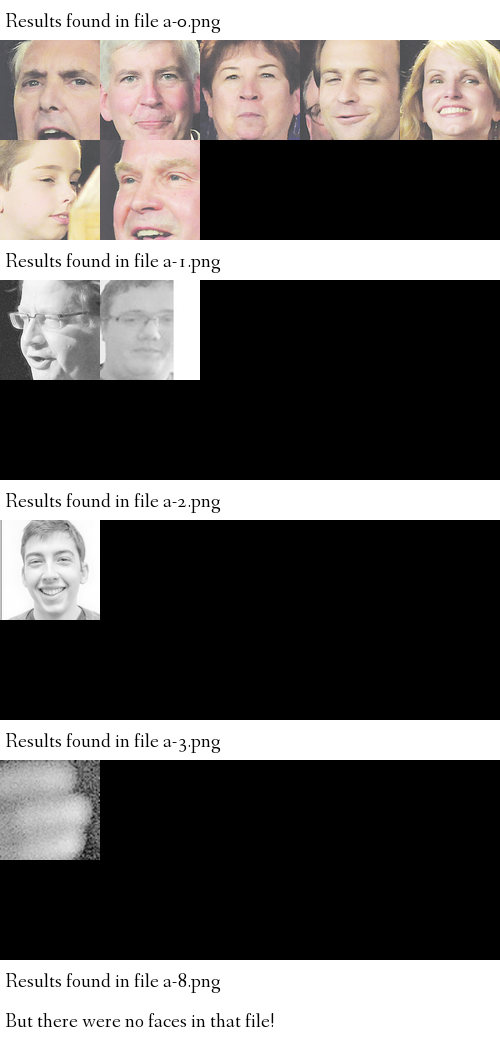

In [45]:
final_output(open_zip('readonly/images.zip'), 'Mark')

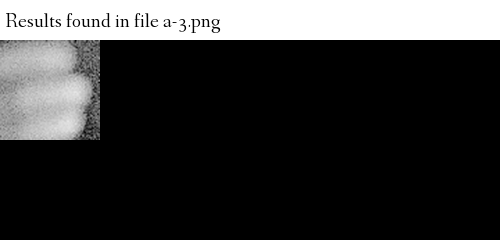

In [46]:
final_output(open_zip('readonly/small_img.zip'), 'Chris')